# ML project 1, S&P stock data

## ML6, Integrify

### Hannu Kiiskinen, 25.11.2023

In [65]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

from dash import Dash, dcc, html, Input, Output, callback

import plotly.express as px

### Dataset

Dataset with historical stock prices (last 5 years) for all companies currently found on the S&P 500 index. Data collected 6 years ago.

License: CC0, Public Domain

In [66]:
# Load data
all_stocks_5yr = pd.read_csv("ML_Project1/all_stocks_5yr.csv")
all_stocks_5yr.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


## Data review

8621 entries, 7 columns.

One field as datetime, six fields as float.

In [67]:
all_stocks_5yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


### Distribution of data

In [68]:
all_stocks_5yr.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


### Features

- Date - in format: yy-mm-dd
- Open - price of the stock at market open (this is NYSE data so all in USD)
- High - Highest price reached in the day
- Low Close - Lowest price reached in the day
- Volume - Number of shares traded
- Name - the stock's ticker name

Note: not target, to be generated

In [69]:
# Change the format
all_stocks_5yr['date'] = pd.to_datetime(all_stocks_5yr['date'])
all_stocks_5yr['Name'] = all_stocks_5yr['Name'].astype('string')
all_stocks_5yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  string        
dtypes: datetime64[ns](1), float64(4), int64(1), string(1)
memory usage: 33.1 MB


In [70]:
# Small amount nan values generated, drop them
all_stocks_5yr = all_stocks_5yr.dropna()

### Generating target values

1    322591
0    296438
Name: target, dtype: int64


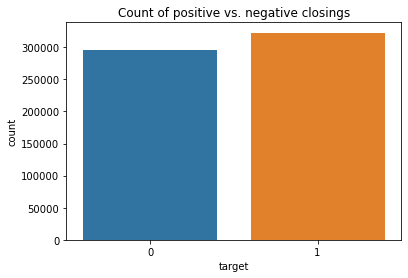

In [71]:
# Define target based on +/- from previous day
all_stocks_5yr['target'] = (all_stocks_5yr['close'].shift(-1) > all_stocks_5yr['close']).astype(int)

print(all_stocks_5yr.target.value_counts())
sns.countplot(x=all_stocks_5yr['target']).set_title('Count of positive vs. negative closings')
plt.show()

In [72]:
# How many compannies, what is the time frame
len(all_stocks_5yr.Name.unique()), all_stocks_5yr.date.unique()

(505,
 array(['2013-02-08T00:00:00.000000000', '2013-02-11T00:00:00.000000000',
        '2013-02-12T00:00:00.000000000', ...,
        '2018-02-05T00:00:00.000000000', '2018-02-06T00:00:00.000000000',
        '2018-02-07T00:00:00.000000000'], dtype='datetime64[ns]'))

### Adding more features

Based on orginal data generate some more features

In [74]:
# Define some new features
all_stocks_5yr['open_close'] = (all_stocks_5yr['close'] - all_stocks_5yr['open'])
all_stocks_5yr['high_low'] = (all_stocks_5yr['high'] - all_stocks_5yr['low'])
all_stocks_5yr

,date,open,high,low,close,volume,Name,target,open_close,high_low
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,0,-0.32,0.49
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,0,-0.43,0.75
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,1,-0.18,0.41
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0,0.36,0.69
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,1,-0.95,1.80
...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,0,0.98,1.58
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,0,-0.75,1.39
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,0,-2.81,3.74
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,1,0.53,2.43


### Visualize features

In [76]:
app = Dash(__name__)

df1 = all_stocks_5yr

app.layout = html.Div(children=[
#    html.H3(children='Ecommerce Dataset'),

    html.Label("Select the Company"),
    dcc.Dropdown(
        id='target-variable',
        options=[{'label': col, 'value': col} for col in all_stocks_5yr.columns[1:5]],
        value=all_stocks_5yr.columns[1]
    ),
    # Radio buttons for selecting visualization type
    html.Label("Select the timeline"),
    dcc.RadioItems(
        id='visualization-type',
        options=[
            {'label': '5 Years', 'value': 'Full'},
            {'label': 'First Year', 'value': 'First Year'},
            {'label': 'Second Year', 'value': 'Second Year'},
            {'label': 'Third Year', 'value': 'Third Year'},
            {'label': 'First Month', 'value': 'First Month'},
            {'label': 'First Week', 'value': 'First Week'},
        ],
        value='Full',
        labelStyle={'display': 'block'}
    ),
    # Graph container
    dcc.Graph(id='graph')
])
# Callback to update the graph based on user input
@app.callback(
    Output('graph', 'figure'),
    [Input('target-variable', 'value'),
     Input('visualization-type', 'value')]
)
def update_graph(target_var, vis_type):
    if vis_type == 'Full':
        df1 = all_stocks_5yr
    elif vis_type == 'First Year':
        df1 = all_stocks_5yr[(all_stocks_5yr['date'] > '2013-02-08') & (all_stocks_5yr['date'] < '2014-02-08')]
    elif vis_type == 'Second Year':
        df1 = all_stocks_5yr[(all_stocks_5yr['date'] > '2014-02-08') & (all_stocks_5yr['date'] < '2015-02-08')]
    elif vis_type == 'Third Year':
        df1 = all_stocks_5yr[(all_stocks_5yr['date'] > '2015-02-08') & (all_stocks_5yr['date'] < '2016-02-08')]
    elif vis_type == 'First Month':
        df1 = all_stocks_5yr[(all_stocks_5yr['date'] > '2013-02-08') & (all_stocks_5yr['date'] < '2013-03-08')]
    elif vis_type == 'First Week':
        df1 = all_stocks_5yr[(all_stocks_5yr['date'] > '2013-02-11') & (all_stocks_5yr['date'] < '2013-02-17')]
    else:
        df1 = all_stocks_5yr[(all_stocks_5yr['date'] > '2013-02-11') & (all_stocks_5yr['date'] < '2013-02-12')]
    fig = px.line(df1, x='date', y=target_var, hover_name="Name", color="Name")
    return fig

if __name__ == '__main__':
    app.run(debug=True)

### Limiting the data by time (because of calculation power)

In [10]:
# Limit the data
all_stocks_1yr = all_stocks_5yr[(all_stocks_5yr['date'] > '2017-02-08') & (all_stocks_5yr['date'] < '2018-02-07')]
all_stocks_1mnth = all_stocks_5yr[(all_stocks_5yr['date'] > '2018-01-08') & (all_stocks_5yr['date'] < '2018-02-07')]
all_stocks_1wk = all_stocks_5yr[(all_stocks_5yr['date'] > '2018-02-01') & (all_stocks_5yr['date'] < '2018-02-07')]

all_stocks_5yr.shape, all_stocks_1yr.shape, all_stocks_1mnth.shape, all_stocks_1wk.shape

((619029, 10), (125657, 10), (10100, 10), (1515, 10))

### Check the correlation

,target,volume,open_close,high_low
target,1.000000,-0.002899,-0.015443,-0.000818
volume,-0.002899,1.000000,-0.006986,-0.070330
open_close,-0.015443,-0.006986,1.000000,-0.034140
high_low,-0.000818,-0.070330,-0.034140,1.000000


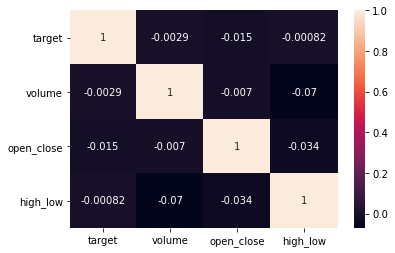

In [11]:
#__________Best Features________________
all_stocks_5yr_fltr = all_stocks_5yr.filter(items=['target', 'volume', 'open_close', 'high_low'])
all_stocks_1yr_fltr = all_stocks_1yr.filter(items=['target', 'volume', 'open_close', 'high_low'])
all_stocks_1mnth_fltr = all_stocks_1mnth.filter(items=['target', 'volume', 'open_close', 'high_low'])
all_stocks_1wk_fltr = all_stocks_1wk.filter(items=['target', 'volume', 'open_close', 'high_low'])

CM = all_stocks_5yr_fltr.corr()
#threshold = 0.6

#features_names = list(CM.columns[np.abs(CM['target'])>=threshold])
#features = CM.loc[:, features_names].loc[features_names, :]

sns.heatmap(CM, annot=True)#
CM

### Split the data

In [12]:
# Use 5yr data if the calculation is fast enough
# _________Split Dataset to Train and Test_____________
train, test = train_test_split(all_stocks_5yr_fltr, test_size=0.2, random_state=31)
X_train, y_train = train.iloc[:, 1:].to_numpy(), train.iloc[:, 0].to_numpy()
X_test, y_test = test.iloc[:, 1:].to_numpy(), test.iloc[:, 0].to_numpy()

# ________Scaling the Features________________

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### First classifier, Logistic Regression

In [13]:
Classifier = LogisticRegression(random_state = 32)
Classifier.fit(X_train, y_train)

lr_preds_train = Classifier.predict(X_train)
acc = round(accuracy_score(y_train, lr_preds_train), 3)*100
print(f'The accuracy of the model is {acc}')

lr_pred_test = Classifier.predict(X_test)
acc = round(accuracy_score(y_test, lr_pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

The accuracy of the model is 52.2
The accuracy of the test is 51.9


### Decision tree

In [18]:
# Make an instance of the Model
clf = DecisionTreeClassifier(max_depth = 25, criterion='entropy')

# Train the model on the data
clf.fit(X_train, y_train)

clf_preds_train = clf.predict(X_train)
acc = round(accuracy_score(y_train, clf_preds_train), 3)*100
print(f'The accuracy of the model is {acc}')

clf_pred_test = clf.predict(X_test)
acc = round(accuracy_score(y_test, clf_pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

The accuracy of the model is 58.3
The accuracy of the test is 51.6


## Randomized Search with SVC

Make limited data for finding the best estimators of SVC's.

In [13]:
# Use 1wk data if the calculation is fast enough
# _________Split Dataset to Train and Test_____________
train_lim, test_lim = train_test_split(all_stocks_1wk_fltr, test_size=0.2, random_state=31)
X_train_lim, y_train_lim = train_lim.iloc[:, 1:].to_numpy(), train_lim.iloc[:, 0].to_numpy()
X_test_lim, y_test_lim = test_lim.iloc[:, 1:].to_numpy(), test_lim.iloc[:, 0].to_numpy()

# ________Scaling the Features________________

sc = StandardScaler()

X_train_lim = sc.fit_transform(X_train_lim)
X_test_lim = sc.transform(X_test_lim)

For SVC the possible full data is not more than 1 year data. 

In [14]:
# Use 1yr data if the calculation is fast enough
# _________Split Dataset to Train and Test_____________
train, test = train_test_split(all_stocks_1yr_fltr, test_size=0.2, random_state=31)
X_train, y_train = train.iloc[:, 1:].to_numpy(), train.iloc[:, 0].to_numpy()
X_test, y_test = test.iloc[:, 1:].to_numpy(), test.iloc[:, 0].to_numpy()

# ________Scaling the Features________________

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Randomized Search/Linear

Find the best estimator with limited data.

In [18]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear'],
    'gamma': [0.01, 0.1, 1, 'scale'],  # 'scale' uses 1 / (n_features * X.var()) as gamma
    'class_weight': [None]  # None means equal class weights
}

RS = RandomizedSearchCV(SVC(), param_grid, cv=3, verbose=3)

RS.fit(X_train_lim, y_train_lim)

preds_train_lim = RS.predict(X_train_lim)
acc = round(accuracy_score(y_train_lim, preds_train_lim), 3)*100
print(f'The accuracy of the model is {acc}')

pred_test_lim = RS.predict(X_test_lim)
acc = round(accuracy_score(y_test_lim, pred_test_lim), 3)*100
print(f'The accuracy of the test is {acc}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END C=1, class_weight=None, gamma=scale, kernel=linear;, score=0.619 total time=   0.0s
[CV 2/3] END C=1, class_weight=None, gamma=scale, kernel=linear;, score=0.621 total time=   0.0s
[CV 3/3] END C=1, class_weight=None, gamma=scale, kernel=linear;, score=0.609 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=None, gamma=0.01, kernel=linear;, score=0.619 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, gamma=0.01, kernel=linear;, score=0.616 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, gamma=0.01, kernel=linear;, score=0.601 total time=   0.0s
[CV 1/3] END C=1, class_weight=None, gamma=0.01, kernel=linear;, score=0.619 total time=   0.0s
[CV 2/3] END C=1, class_weight=None, gamma=0.01, kernel=linear;, score=0.621 total time=   0.0s
[CV 3/3] END C=1, class_weight=None, gamma=0.01, kernel=linear;, score=0.609 total time=   0.0s
[CV 1/3] END C=10, class_weight=None, gamma=0.1, kernel=linear;, s

In [19]:
# Take the best estimator
RS.best_estimator_

SVC(C=1, kernel='linear')

### SVC/linear

Test the best estimator with 1 year data.

In [20]:
svc = SVC(C=1, kernel='linear')
svc.fit(X_train, y_train)

preds_train = svc.predict(X_train)
acc = round(accuracy_score(y_train, preds_train), 3)*100
print(f'The accuracy of the model is {acc}')

pred_test = svc.predict(X_test)
acc = round(accuracy_score(y_test, pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

The accuracy of the model is 52.7
The accuracy of the test is 52.6


### Randomized Search / poly

Find the best estimator with limited data.

In [27]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['poly'],
    'degree': [2, 3, 4],  # Only for polynomial kernel
    'gamma': [0.01, 0.1, 1, 'scale'],  # 'scale' uses 1 / (n_features * X.var()) as gamma
    'class_weight': [None]  # None means equal class weights
}

RS = RandomizedSearchCV(SVC(), param_grid, cv=3, verbose=3)

RS.fit(X_train_lim, y_train_lim)

preds_train_lim = RS.predict(X_train_lim)
acc = round(accuracy_score(y_train_lim, preds_train_lim), 3)*100
print(f'The accuracy of the model is {acc}')

pred_test_lim = RS.predict(X_test_lim)
acc = round(accuracy_score(y_test_lim, pred_test_lim), 3)*100
print(f'The accuracy of the test is {acc}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END C=1, class_weight=None, degree=3, gamma=scale, kernel=poly;, score=0.587 total time=   0.3s
[CV 2/3] END C=1, class_weight=None, degree=3, gamma=scale, kernel=poly;, score=0.604 total time=   0.0s
[CV 3/3] END C=1, class_weight=None, degree=3, gamma=scale, kernel=poly;, score=0.601 total time=   0.1s
[CV 1/3] END C=0.1, class_weight=None, degree=4, gamma=0.01, kernel=poly;, score=0.587 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, degree=4, gamma=0.01, kernel=poly;, score=0.592 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, degree=4, gamma=0.01, kernel=poly;, score=0.592 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=None, degree=2, gamma=0.1, kernel=poly;, score=0.584 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, degree=2, gamma=0.1, kernel=poly;, score=0.599 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, degree=2, gamma=0.1, kernel=poly;, score=0.594 total time

In [28]:
# Take the best estimator
RS.best_estimator_

SVC(C=1, kernel='poly')

### SVC/poly

Test the best estimator with 1 year data.
#### <font color='red'>Not possible to execute at the end, after 36 hours running I cancelled it.</font>

In [ ]:
svc2 = SVC(C=1, kernel='poly')
svc2.fit(X_train, y_train)

svc2_preds_train = svc2.predict(X_train)
acc = round(accuracy_score(y_train, svc2_preds_train), 3)*100
print(f'The accuracy of the model is {acc}')

svc2_pred_test = svc2.predict(X_test)
acc = round(accuracy_score(y_test, svc2_pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

### Randomized Search / rbf

Find the best estimator with limited data.

In [24]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [0.01, 0.1, 1, 'scale'],  # 'scale' uses 1 / (n_features * X.var()) as gamma
    'class_weight': [None]  # None means equal class weights
}

RS = RandomizedSearchCV(SVC(), param_grid, cv=3, verbose=3)

RS.fit(X_train_lim, y_train_lim)

preds_train_lim = RS.predict(X_train_lim)
acc = round(accuracy_score(y_train_lim, preds_train_lim), 3)*100
print(f'The accuracy of the model is {acc}')

pred_test_lim = RS.predict(X_test_lim)
acc = round(accuracy_score(y_test_lim, pred_test_lim), 3)*100
print(f'The accuracy of the test is {acc}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END C=10, class_weight=None, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 2/3] END C=10, class_weight=None, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 3/3] END C=10, class_weight=None, gamma=0.1, kernel=rbf;, score=0.629 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=None, gamma=1, kernel=rbf;, score=0.641 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, gamma=1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, gamma=1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 1/3] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.641 total time=   0.0s
[CV 2/3] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.621 total time=   0.0s
[CV 3/3] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.646 total time=   0.0s
[CV 1/3] END C=10, class_weight=None, gamma=scale, kernel=rbf;, score=0.621 total time=   0.0s
[

In [25]:
# Take the best estimator
RS.best_estimator_

SVC(C=100)

### SVC/rbf

Test the best estimator with 1 year data.

In [26]:
svc3 = SVC(C=100, kernel='rbf')
svc3.fit(X_train, y_train)

svc3_preds_train = svc3.predict(X_train)
acc = round(accuracy_score(y_train, svc3_preds_train), 3)*100
print(f'The accuracy of the model is {acc}')

svc3_pred_test = svc3.predict(X_test)
acc = round(accuracy_score(y_test, svc3_pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

The accuracy of the model is 53.2
The accuracy of the test is 52.6


### Generate more features

Are the years brothers to each others, what about months sisters to each other, how about weeks?

In [32]:
# Define new feature week based on closing difference from previous week
all_stocks_5yr['week'] = (all_stocks_5yr['close'].shift(-5) > all_stocks_5yr['close']).astype(int)
all_stocks_5yr_week = all_stocks_5yr
all_stocks_5yr_week.head(10)

,date,open,high,low,close,volume,Name,target,open_close,high_low,year,month,day,week
252,2014-02-10,36.10,36.1500,35.38,35.580,11110235,AAL,0,-0.520,0.7700,2014,2,10,0
253,2014-02-11,35.58,35.6400,34.39,35.130,11990875,AAL,0,-0.450,1.2500,2014,2,11,0
254,2014-02-12,34.89,35.0000,34.36,34.690,9386780,AAL,1,-0.200,0.6400,2014,2,12,1
255,2014-02-13,34.07,35.0400,34.06,35.025,8412272,AAL,0,0.955,0.9800,2014,2,13,1
256,2014-02-14,34.85,35.1760,34.22,34.410,7307286,AAL,0,-0.440,0.9560,2014,2,14,1
257,2014-02-18,34.73,34.9500,34.20,34.310,7090152,AAL,1,-0.420,0.7500,2014,2,18,1
258,2014-02-19,34.25,35.0900,34.11,34.590,7259501,AAL,1,0.340,0.9800,2014,2,19,1
259,2014-02-20,34.43,35.6694,34.43,35.660,9289448,AAL,1,1.230,1.2394,2014,2,20,1
260,2014-02-21,35.78,36.4500,35.75,36.170,7821334,AAL,1,0.390,0.7000,2014,2,21,1
261,2014-02-24,36.20,36.6600,36.02,36.650,7022370,AAL,1,0.450,0.6400,2014,2,24,0


In [33]:
# The first week values incorrect, drop them
all_stocks_5yr_week.drop(all_stocks_5yr_week[all_stocks_5yr_week.date < '2013-02-15'].index, inplace=True)
all_stocks_5yr_week.head()

,date,open,high,low,close,volume,Name,target,open_close,high_low,year,month,day,week
252,2014-02-10,36.10,36.150,35.38,35.580,11110235,AAL,0,-0.520,0.770,2014,2,10,0
253,2014-02-11,35.58,35.640,34.39,35.130,11990875,AAL,0,-0.450,1.250,2014,2,11,0
254,2014-02-12,34.89,35.000,34.36,34.690,9386780,AAL,1,-0.200,0.640,2014,2,12,1
255,2014-02-13,34.07,35.040,34.06,35.025,8412272,AAL,0,0.955,0.980,2014,2,13,1
256,2014-02-14,34.85,35.176,34.22,34.410,7307286,AAL,0,-0.440,0.956,2014,2,14,1


In [34]:
# Define new feature month based on closing difference from previous month
all_stocks_5yr['month'] = (all_stocks_5yr['close'].shift(-21) > all_stocks_5yr['close']).astype(int)
all_stocks_5yr_month = all_stocks_5yr

# The first month values incorrect, drop them
all_stocks_5yr_month.drop(all_stocks_5yr_month[all_stocks_5yr_month.date < '2013-03-08'].index, inplace=True)
all_stocks_5yr_month.head()

,date,open,high,low,close,volume,Name,target,open_close,high_low,year,month,day,week
252,2014-02-10,36.10,36.150,35.38,35.580,11110235,AAL,0,-0.520,0.770,2014,1,10,0
253,2014-02-11,35.58,35.640,34.39,35.130,11990875,AAL,0,-0.450,1.250,2014,1,11,0
254,2014-02-12,34.89,35.000,34.36,34.690,9386780,AAL,1,-0.200,0.640,2014,1,12,1
255,2014-02-13,34.07,35.040,34.06,35.025,8412272,AAL,0,0.955,0.980,2014,1,13,1
256,2014-02-14,34.85,35.176,34.22,34.410,7307286,AAL,0,-0.440,0.956,2014,1,14,1


In [35]:
# Define new feature year based on closing difference from previous year
all_stocks_5yr['year'] = (all_stocks_5yr['close'].shift(-260) > all_stocks_5yr['close']).astype(int)
all_stocks_5yr_year = all_stocks_5yr

# The first month values incorrect, drop them
all_stocks_5yr_year.drop(all_stocks_5yr_year[all_stocks_5yr_year.date < '2014-02-08'].index, inplace=True)
all_stocks_5yr_year.head()

,date,open,high,low,close,volume,Name,target,open_close,high_low,year,month,day,week
252,2014-02-10,36.10,36.150,35.38,35.580,11110235,AAL,0,-0.520,0.770,1,1,10,0
253,2014-02-11,35.58,35.640,34.39,35.130,11990875,AAL,0,-0.450,1.250,1,1,11,0
254,2014-02-12,34.89,35.000,34.36,34.690,9386780,AAL,1,-0.200,0.640,1,1,12,1
255,2014-02-13,34.07,35.040,34.06,35.025,8412272,AAL,0,0.955,0.980,1,1,13,1
256,2014-02-14,34.85,35.176,34.22,34.410,7307286,AAL,0,-0.440,0.956,1,1,14,1


### Check the correlation of new features and target

,target,volume,week,month,year
target,1.000000,-0.003409,0.285282,0.127674,0.022035
volume,-0.003409,1.000000,-0.003073,0.004295,0.041220
week,0.285282,-0.003073,1.000000,0.307318,0.049555
month,0.127674,0.004295,0.307318,1.000000,0.119024
year,0.022035,0.041220,0.049555,0.119024,1.000000


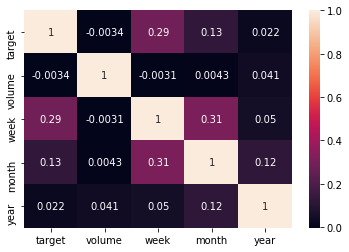

In [17]:
#__________Best Features________________
all_stocks_5yr_year_fltr = all_stocks_5yr_year.filter(items=['target', 'volume', 'week', 'month', 'year'])

CM = all_stocks_5yr_year_fltr.corr()
#threshold = 0.6

#features_names = list(CM.columns[np.abs(CM['target'])>=threshold])
#features = CM.loc[:, features_names].loc[features_names, :]

sns.heatmap(CM, annot=True)#
CM

### Use new features

In [18]:
#__________Best Feature only________________
all_stocks_5yr_use_fltr = all_stocks_5yr_week.filter(items=['target', 'week'])

# _________Split Dataset to Train and Test_____________
train, test = train_test_split(all_stocks_5yr_use_fltr, test_size=0.2, random_state=31)
X_train, y_train = train.iloc[:, 1:].to_numpy(), train.iloc[:, 0].to_numpy()
X_test, y_test = test.iloc[:, 1:].to_numpy(), test.iloc[:, 0].to_numpy()

# ________Scaling the Features________________

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### First classifier, Logistic regression

In [19]:
Classifier = LogisticRegression(random_state = 0)
Classifier.fit(X_train, y_train)

lr_preds_train = Classifier.predict(X_train)
acc = round(accuracy_score(y_train, lr_preds_train), 3)*100
print(f'The accuracy of the model is {acc}')

lr_pred_test = Classifier.predict(X_test)
acc = round(accuracy_score(y_test, lr_pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

#cm = confusion_matrix(y_test, lr_pred_test)
#sns.heatmap(cm, annot=True)

The accuracy of the model is 64.4
The accuracy of the test is 64.3


### Second classifier, Decision tree

In [20]:
# Make an instance of the Model
clf = DecisionTreeClassifier(max_depth = 6, criterion='entropy')

# Train the model on the data
clf.fit(X_train, y_train)

clf_preds_train = clf.predict(X_train)
acc = round(accuracy_score(y_train, clf_preds_train), 3)*100
print(f'The accuracy of the model is {acc}')

clf_pred_test = clf.predict(X_test)
acc = round(accuracy_score(y_test, clf_pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

The accuracy of the model is 64.4
The accuracy of the test is 64.3


### Ensamble/Stacking

In [21]:
meta_model = LogisticRegression()

# LR = lr_preds_train
# DS = clf_preds_train

Train_stacked_X = np.column_stack((lr_preds_train, clf_preds_train))
meta_model.fit(Train_stacked_X, y_train)
Train_meta_pred = meta_model.predict(Train_stacked_X)

accuracy = accuracy_score(y_train, Train_meta_pred)
print("Train Accuracy:", round(accuracy, 3)*100)

# LR = lr_pred_test
# DS = clf_pred_test

Test_stacked_X = np.column_stack((lr_pred_test, clf_pred_test))
final_pred = meta_model.predict(Test_stacked_X)

accuracy = accuracy_score(y_test, final_pred)
print("Test Accuracy:", round(accuracy, 3)*100)

Train Accuracy: 64.4
Test Accuracy: 64.3


### Ensamble/Blending

In [22]:
Train_blended_X = np.column_stack((X_train, lr_preds_train, clf_preds_train))
Test_blended_X = np.column_stack((X_test, lr_pred_test, clf_pred_test))

meta_model_Bl = LogisticRegression()
meta_model_Bl.fit(Train_blended_X, y_train)
Bl_meta_pred = meta_model_Bl.predict(Train_blended_X)

accuracy = accuracy_score(y_train, Bl_meta_pred)
print("Train Accuracy:", round(accuracy, 3)*100)

final_pred_Bl = meta_model_Bl.predict(Test_blended_X)

accuracy = accuracy_score(y_test, final_pred_Bl)
print("Test Accuracy:", round(accuracy, 3)*100)

Train Accuracy: 64.4
Test Accuracy: 64.3


### Random Forrest classifier

In [23]:
clf = RandomForestClassifier(max_depth=15, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)*100
confusion_mat = confusion_matrix(y_test,y_pred)

# Printing the results
print("Accuracy for RandomForrest is:", round(accuracy, 1))
print("Confusion Matrix")
print(confusion_mat)

Accuracy for RandomForrest is: 64.3
Confusion Matrix
[[29027 18939]
 [16639 35002]]


### AdaBoost

In [24]:
clf = AdaBoostClassifier(n_estimators=40, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)*100
confusion_mat = confusion_matrix(y_test,y_pred)

# Printing the results
print("Accuracy for AdaBoost is:", round(accuracy, 1))
print("Confusion Matrix")
print(confusion_mat)

Accuracy for AdaBoost is: 64.3
Confusion Matrix
[[29027 18939]
 [16639 35002]]


### Splitting date to years, months and weekdays

In [50]:
# Create new columns
all_stocks_5yr['by_year'] = all_stocks_5yr['date'].dt.year
all_stocks_5yr['by_month'] = all_stocks_5yr['date'].dt.month
all_stocks_5yr['by_date'] = all_stocks_5yr['date'].dt.day
all_stocks_5yr['by_day'] = all_stocks_5yr['date'].dt.dayofweek
all_stocks_5yr

,date,open,high,low,close,volume,Name,target,open_close,high_low,by_year,by_month,by_date,by_day
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,0,-0.32,0.49,2013,2,8,4
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,0,-0.43,0.75,2013,2,11,0
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,1,-0.18,0.41,2013,2,12,1
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0,0.36,0.69,2013,2,13,2
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,1,-0.95,1.80,2013,2,14,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,0,0.98,1.58,2018,2,1,3
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,0,-0.75,1.39,2018,2,2,4
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,0,-2.81,3.74,2018,2,5,0
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,1,0.53,2.43,2018,2,6,1


In [57]:
#__________Best Features________________
all_stocks_5yr_year_fltr1 = all_stocks_5yr.filter(items=['target', 'volume', 'open_close', 'high_low', 'by_year', 'by_month',
                                                        'by_date', 'by_day'])

# _________Split Dataset to Train and Test_____________
train, test = train_test_split(all_stocks_5yr_year_fltr1, test_size=0.2, random_state=31)
X_train, y_train = train.iloc[:, 1:].to_numpy(), train.iloc[:, 0].to_numpy()
X_test, y_test = test.iloc[:, 1:].to_numpy(), test.iloc[:, 0].to_numpy()

# ________Scaling the Features________________

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [58]:
clf = RandomForestClassifier(max_depth=15, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)*100
confusion_mat = confusion_matrix(y_test,y_pred)

# Printing the results
print("Accuracy for RandomForrest is:", round(accuracy, 1))
print("Confusion Matrix")
print(confusion_mat)

Accuracy for RandomForrest is: 68.9
Confusion Matrix
[[35862 23633]
 [14874 49437]]


In [59]:
# Create new columns
all_stocks_5yr_year['by_year'] = all_stocks_5yr_year['date'].dt.year
all_stocks_5yr_year['by_month'] = all_stocks_5yr_year['date'].dt.month
all_stocks_5yr_year['by_date'] = all_stocks_5yr_year['date'].dt.day
all_stocks_5yr_year['by_day'] = all_stocks_5yr_year['date'].dt.dayofweek
all_stocks_5yr_year

,date,open,high,low,close,volume,Name,target,open_close,high_low,year,month,day,week,by_year,by_month,by_day,by_date
252,2014-02-10,36.10,36.150,35.38,35.580,11110235,AAL,0,-0.520,0.770,1,1,10,0,2014,2,0,10
253,2014-02-11,35.58,35.640,34.39,35.130,11990875,AAL,0,-0.450,1.250,1,1,11,0,2014,2,1,11
254,2014-02-12,34.89,35.000,34.36,34.690,9386780,AAL,1,-0.200,0.640,1,1,12,1,2014,2,2,12
255,2014-02-13,34.07,35.040,34.06,35.025,8412272,AAL,0,0.955,0.980,1,1,13,1,2014,2,3,13
256,2014-02-14,34.85,35.176,34.22,34.410,7307286,AAL,0,-0.440,0.956,1,1,14,1,2014,2,4,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.270,76.69,77.820,2982259,ZTS,0,0.980,1.580,0,0,1,0,2018,2,3,1
619036,2018-02-02,77.53,78.120,76.73,76.780,2595187,ZTS,0,-0.750,1.390,0,0,2,0,2018,2,4,2
619037,2018-02-05,76.64,76.920,73.18,73.830,2962031,ZTS,0,-2.810,3.740,0,0,5,0,2018,2,0,5
619038,2018-02-06,72.74,74.560,72.13,73.270,4924323,ZTS,1,0.530,2.430,0,0,6,0,2018,2,1,6


In [60]:
#__________Best Features________________
all_stocks_5yr_year_fltr2 = all_stocks_5yr_year.filter(items=['target', 'volume', 'open_close', 'high_low', 'by_year', 'by_month',
                                                        'by_date', 'by_day', 'year', 'month', 'week'])

# _________Split Dataset to Train and Test_____________
train, test = train_test_split(all_stocks_5yr_year_fltr2, test_size=0.2, random_state=31)
X_train, y_train = train.iloc[:, 1:].to_numpy(), train.iloc[:, 0].to_numpy()
X_test, y_test = test.iloc[:, 1:].to_numpy(), test.iloc[:, 0].to_numpy()

# ________Scaling the Features________________

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [62]:
clf = RandomForestClassifier(max_depth=25, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)*100
confusion_mat = confusion_matrix(y_test,y_pred)

# Printing the results
print("Accuracy for RandomForrest is:", round(accuracy, 1))
print("Confusion Matrix")
print(confusion_mat)

Accuracy for RandomForrest is: 70.8
Confusion Matrix
[[32608 15358]
 [13712 37929]]


### Conclusions

By generating new features it is possible to improve the accuracy from 52 to 70.8 %.

Please note that all models are just trying to estimate if there is a raise of the closing value from previous day and amount of raise is not counted or predicted.